### Neale Ellyson
## MSE 608: Project 8

In [70]:
#l = [int(x) for x in input().split(',')]
#array_1 = l[::2]
#array_2 = l[1::2]
#print(l,array_1,array_2)
print('Input:',input())

here
Input: here


In [88]:
N = 40
fA = 0.5
fBN = int((1-fA)*N)
a = numpy.repeat(numpy.arange(N),2)
bondgroup = a[1:-1].reshape(len(a[1:-1])//2,2)
print(numpy.arange(N)[0:(fBN)])
print(numpy.arange(10,51,10))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[10 20 30 40 50]


In [101]:
import hoomd
import hoomd.md
import numpy
import ex_render
import freud 
import matplotlib.pyplot as plt
import time
%matplotlib inline
fractions = {}
data = {}
EQfrac = {}
EQdata = {}
analysis = {}
EQanalysis = {}

In [102]:
class rdf_analyze:
    def __init__(self, system):
        self.system = system;
        self.rdf = freud.density.RDF(rmax=1.0, dr=0.01); #Can update range and stepsize here
        
    def __call__(self, step):
        '''This special function defines what happens when we "register" the callback below'''
        snap = self.system.take_snapshot();
        pos = snap.particles.position;
        box = freud.box.Box(snap.box.Lx, snap.box.Ly, snap.box.Lz);
        self.rdf.accumulate(box, pos, pos);

In [103]:
def size(N): # Creates position vectors and bond groups for
    line = numpy.linspace(-(N//2-.5),(N//2-.5),num=N)
    position = numpy.insert(numpy.zeros((N,2)), 0, line, axis=1)
    a = numpy.repeat(numpy.arange(N),2)
    bondgroup = a[1:-1].reshape(len(a[1:-1])//2,2)
    return position,bondgroup

In [110]:
def run(N,fA,position,bondgroup,kT,tau,period,tsteps):
    fBN = int((1-fA)*N)
    hoomd.context.initialize("");
    # Mike says "This is initializing the longer way than a lattice"
    snapshot = hoomd.data.make_snapshot(N=N, # Number of atoms in a particle
                                        box=hoomd.data.boxdim(Lx=N, Ly=0.5, Lz=0.5),
                                        particle_types=['A', 'B'],
                                        bond_types=['polymer']); # Single bond type
    print(snapshot.particles.position[:])
    print(position)
    snapshot.particles.position[:] = position
    snapshot.particles.typeid[0:(fBN)]=0;  # Blue particles = A
    snapshot.particles.typeid[(fBN):N]=1; # Orange particles = B
    snapshot.bonds.resize(N-1);
    snapshot.bonds.group[:] = bondgroup
    snapshot.replicate(1,2*N,2*N); # Makes boxdim equal across the L dimensions
    hoomd.init.read_snapshot(snapshot);
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
    dpd.pair_coeff.set('A', 'B', A=75.0, gamma = 1.0);
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);
    nl.reset_exclusions(exclusions = []);
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=0);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log(filename="size-"+str(N)+"frac-"+str(fA)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
    hoomd.dump.gsd("traj-size-"+str(N)+"frac-"+str(fA)+".gsd", period=tsteps/10 , group=all, overwrite=True);
    hoomd.run(tsteps);
    data = numpy.genfromtxt(fname="size-"+str(N)+"frac-"+str(fA)+".log", skip_header=True);
    return data

In [111]:
N = 10
position, bondgroup = size(N)
fA = 0.1
fBN = int((1-fA)*N)
kT = 1
tau = 0.1
period = 100
tsteps = 1e4
hoomd.context.initialize("");
# Mike says "This is initializing the longer way than a lattice"
snapshot = hoomd.data.make_snapshot(N=N, # Number of atoms in a particle
                                    box=hoomd.data.boxdim(Lx=N, Ly=0.5, Lz=0.5),
                                    particle_types=['A', 'B'],
                                    bond_types=['polymer']); # Single bond type

snapshot.particles.position[:] = position
snapshot.particles.typeid[0:5]=0;  # Blue particles = A
snapshot.particles.typeid[6:N]=1; # Orange particles = B
print(snapshot.particles.position[:])
print(position)

[[-4.5  0.   0. ]
 [-3.5  0.   0. ]
 [-2.5  0.   0. ]
 [-1.5  0.   0. ]
 [-0.5  0.   0. ]
 [ 0.5  0.   0. ]
 [ 1.5  0.   0. ]
 [ 2.5  0.   0. ]
 [ 3.5  0.   0. ]
 [ 4.5  0.   0. ]]
[[-4.5  0.   0. ]
 [-3.5  0.   0. ]
 [-2.5  0.   0. ]
 [-1.5  0.   0. ]
 [-0.5  0.   0. ]
 [ 0.5  0.   0. ]
 [ 1.5  0.   0. ]
 [ 2.5  0.   0. ]
 [ 3.5  0.   0. ]
 [ 4.5  0.   0. ]]


In [108]:
def EQrun(kT,tau,period,tsteps):
    hoomd.context.initialize("");
    system = hoomd.init.read_gsd("traj-size-"+str(N)+"frac-"+str(fA)+".gsd", frame=-1, time_step=0)
    EQanalysis = rdf_analyze(system); # Create the RDF analyzer using our class in the above cell
    hoomd.analyze.callback(EQanalysis, period=period); #Registration of the RDF callback every 100 steps
    nl = hoomd.md.nlist.cell();
    dpd = hoomd.md.pair.dpd(r_cut=1.0, nlist=nl, kT=kT, seed=1); # NOT Dissipative Particle Dynamics, LJ
    dpd.pair_coeff.set('A', 'A', A=25.0, gamma = 1.0);
    dpd.pair_coeff.set('A', 'B', A=75.0, gamma = 1.0);
    dpd.pair_coeff.set('B', 'B', A=25.0, gamma = 1.0);
    nl.reset_exclusions(exclusions = []);
    harmonic = hoomd.md.bond.harmonic();
    harmonic.bond_coeff.set('polymer', k=100.0, r0=0);
    hoomd.md.integrate.mode_standard(dt=0.005);
    all = hoomd.group.all();
    integrator = hoomd.md.integrate.nvt(group=all,kT=kT,tau=tau);
    integrator.randomize_velocities(seed=42)
    hoomd.analyze.log(filename="EQ-size-"+str(N)+"frac-"+str(fA)+".log",
                      quantities=['potential_energy','kinetic_energy','temperature','time'],
                      period=period ,
                      overwrite=True);
    hoomd.dump.gsd("EQtraj-size-"+str(N)+"frac-"+str(fA)+".gsd", period=tsteps/10 , group=all, overwrite=True);
    hoomd.run(tsteps);
    data = numpy.genfromtxt(fname="EQ-size-"+str(N)+"frac-"+str(fA)+".log", skip_header=True);
    return data,EQanalysis

In [99]:
numpy.arange(0.1,0.6,10.1)

array([0.1])

In [ ]:
#N = 10 # Must be at least 10 and an even number; 40,~5:56min; 30,~2:24min; 20,~0:38
#kT = 1 # Using range 0.1<kT<10
Sizes = numpy.arange(10,51,10)
VolFrac = numpy.arange(0.1,0.6,10.1)
tau = 0.1
period = 100
tsteps = 1e4
start = time.time()
for N in Sizes:
    pos,bonds = size(N)
    onerun = []
    oneEQrun = []
    analysisrun = []
    for fA in VolFrac:
        print("\n Starting run with",N,"particles at a fraction of", fA,"\n")
        fractions[fA] = run(N,fA,pos,bonds,kT,tau,period,tsteps)
        onerun.append(fractions[fA])
        data[N] =  numpy.array(onerun)
        print("\n Starting Equilirbrium Run")
        EQfrac[fA],analysis[fA] = EQrun(kT,tau,period,tsteps)
        oneEQrun.append(EQfrac[fA])
        analysisrun.append(analysis[fA])
        EQdata[N] = numpy.array(oneEQrun)
        EQanalysis[N] = numpy.array(analysisrun)
finish = time.time()
print('This took',(finish-start)/60,'minutes, or',(finish-start)/60/60,'hours')


 Starting run with 10 particles at a fraction of 0.1 

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[-4.5  0.   0. ]
 [-3.5  0.   0. ]
 [-2.5  0.   0. ]
 [-1.5  0.   0. ]
 [-0.5  0.   0. ]
 [ 0.5  0.   0. ]
 [ 1.5  0.   0. ]
 [ 2.5  0.   0. ]
 [ 3.5  0.   0. ]
 [ 4.5  0.   0. ]]
notice(2): Group "all" created containing 4000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 4000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 1735 / 10000 | TPS 173.482 | ETA 00:00:4

Time 00:01:30 | Step 2289 / 10000 | TPS 25.9893 | ETA 00:04:56
Time 00:01:40 | Step 2536 / 10000 | TPS 24.6829 | ETA 00:05:02
Time 00:01:50 | Step 2794 / 10000 | TPS 25.7858 | ETA 00:04:39
Time 00:02:00 | Step 3040 / 10000 | TPS 24.5259 | ETA 00:04:43
Time 00:02:10 | Step 3282 / 10000 | TPS 24.1934 | ETA 00:04:37
Time 00:02:20 | Step 3532 / 10000 | TPS 24.9954 | ETA 00:04:18
Time 00:02:30 | Step 3790 / 10000 | TPS 25.7615 | ETA 00:04:01
Time 00:02:40 | Step 4044 / 10000 | TPS 25.2539 | ETA 00:03:55
Time 00:02:50 | Step 4301 / 10000 | TPS 25.3643 | ETA 00:03:44
Time 00:03:00 | Step 4560 / 10000 | TPS 25.6705 | ETA 00:03:31
Time 00:03:10 | Step 4819 / 10000 | TPS 25.7143 | ETA 00:03:21
Time 00:03:20 | Step 5080 / 10000 | TPS 26.0734 | ETA 00:03:08
Time 00:03:30 | Step 5336 / 10000 | TPS 25.3749 | ETA 00:03:03
Time 00:03:40 | Step 5596 / 10000 | TPS 25.7596 | ETA 00:02:50
Time 00:03:50 | Step 5853 / 10000 | TPS 25.6895 | ETA 00:02:41
Time 00:04:01 | Step 6109 / 10000 | TPS 25.5399 | ETA 0

Time 00:11:42 | Step 3893 / 10000 | TPS 7.25178 | ETA 00:14:02
Time 00:11:52 | Step 3967 / 10000 | TPS 7.38058 | ETA 00:13:37
Time 00:12:02 | Step 4038 / 10000 | TPS 7.06178 | ETA 00:14:04
Time 00:12:12 | Step 4108 / 10000 | TPS 6.81231 | ETA 00:14:24
Time 00:12:22 | Step 4180 / 10000 | TPS 7.13286 | ETA 00:13:35
Time 00:12:32 | Step 4249 / 10000 | TPS 6.84082 | ETA 00:14:00
Time 00:12:42 | Step 4321 / 10000 | TPS 7.16188 | ETA 00:13:12
Time 00:12:52 | Step 4393 / 10000 | TPS 7.16814 | ETA 00:13:02
Time 00:13:02 | Step 4465 / 10000 | TPS 7.14462 | ETA 00:12:54
Time 00:13:12 | Step 4537 / 10000 | TPS 7.17605 | ETA 00:12:41
Time 00:13:22 | Step 4609 / 10000 | TPS 7.16411 | ETA 00:12:32
Time 00:13:33 | Step 4684 / 10000 | TPS 7.27051 | ETA 00:12:11
Time 00:13:43 | Step 4758 / 10000 | TPS 7.19429 | ETA 00:12:08
Time 00:13:53 | Step 4827 / 10000 | TPS 6.84321 | ETA 00:12:35
Time 00:14:03 | Step 4899 / 10000 | TPS 7.18924 | ETA 00:11:49
Time 00:14:13 | Step 4970 / 10000 | TPS 7.07915 | ETA 0

Time 00:05:08 | Step 2152 / 10000 | TPS 7.36735 | ETA 00:17:45
Time 00:05:18 | Step 2227 / 10000 | TPS 7.22776 | ETA 00:17:55
Time 00:05:28 | Step 2301 / 10000 | TPS 7.24455 | ETA 00:17:42
Time 00:05:38 | Step 2377 / 10000 | TPS 7.55771 | ETA 00:16:48
Time 00:05:48 | Step 2452 / 10000 | TPS 7.33782 | ETA 00:17:08
Time 00:05:59 | Step 2526 / 10000 | TPS 7.35114 | ETA 00:16:56
Time 00:06:09 | Step 2601 / 10000 | TPS 7.38626 | ETA 00:16:41
Time 00:06:19 | Step 2677 / 10000 | TPS 7.5684 | ETA 00:16:07
Time 00:06:29 | Step 2748 / 10000 | TPS 7.05462 | ETA 00:17:07
Time 00:06:39 | Step 2817 / 10000 | TPS 6.73917 | ETA 00:17:45
Time 00:06:49 | Step 2892 / 10000 | TPS 7.38557 | ETA 00:16:02
Time 00:06:59 | Step 2965 / 10000 | TPS 7.27553 | ETA 00:16:06
Time 00:07:09 | Step 3034 / 10000 | TPS 6.8683 | ETA 00:16:54
Time 00:07:19 | Step 3107 / 10000 | TPS 7.25969 | ETA 00:15:49
Time 00:07:29 | Step 3181 / 10000 | TPS 7.34602 | ETA 00:15:28
Time 00:07:39 | Step 3252 / 10000 | TPS 7.04253 | ETA 00:

notice(2): Group "all" created containing 256000 particles
-----
You are using DPD. Please cite the following:
* C L Phillips, J A Anderson, and S C Glotzer. "Pseudo-random number generation
  for Brownian Dynamics and Dissipative Particle Dynamics simulations on GPU
  devices", Journal of Computational Physics 230 (2011) 7191--7201
-----
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 256000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:11 | Step 18 / 10000 | TPS 1.6504 | ETA 01:40:48
Time 00:00:21 | Step 41 / 10000 | TPS 2.25777 | ETA 01:13:30
Time 00:00:31 | Step 64 / 10000 | TPS 2.25087 | ETA 01:13:34
Time 00:00:42 | Step 94 / 10000 | TPS 2.79273 | ETA 00:59:07
Time 00:00:53 | Step 122 / 10000 | TPS 2.5697 | ETA 01:04:04
Time 00:01:03 | Step 149 / 10000 | TPS 2.55298 | ETA 01:04:18
Time 00:01:13 | Step 177 / 10000 | TPS 2.75762 | 

Time 00:21:20 | Step 2446 / 10000 | TPS 2.45469 | ETA 00:51:17
Time 00:21:31 | Step 2470 / 10000 | TPS 2.27034 | ETA 00:55:16
Time 00:21:41 | Step 2494 / 10000 | TPS 2.38295 | ETA 00:52:29
Time 00:21:51 | Step 2517 / 10000 | TPS 2.25234 | ETA 00:55:22
Time 00:22:01 | Step 2543 / 10000 | TPS 2.57304 | ETA 00:48:18
Time 00:22:11 | Step 2565 / 10000 | TPS 2.17412 | ETA 00:56:59
Time 00:22:21 | Step 2588 / 10000 | TPS 2.29928 | ETA 00:53:43
Time 00:22:32 | Step 2613 / 10000 | TPS 2.43147 | ETA 00:50:38
Time 00:22:42 | Step 2636 / 10000 | TPS 2.24247 | ETA 00:54:43
Time 00:22:52 | Step 2660 / 10000 | TPS 2.34848 | ETA 00:52:05
Time 00:23:03 | Step 2687 / 10000 | TPS 2.45258 | ETA 00:49:41
Time 00:23:13 | Step 2711 / 10000 | TPS 2.37145 | ETA 00:51:13
Time 00:23:23 | Step 2736 / 10000 | TPS 2.45733 | ETA 00:49:16
Time 00:23:34 | Step 2762 / 10000 | TPS 2.54372 | ETA 00:47:25
Time 00:23:44 | Step 2790 / 10000 | TPS 2.76086 | ETA 00:43:31
Time 00:23:54 | Step 2815 / 10000 | TPS 2.37222 | ETA 0

Time 00:43:48 | Step 6342 / 10000 | TPS 2.98972 | ETA 00:20:23
Time 00:43:58 | Step 6372 / 10000 | TPS 2.98969 | ETA 00:20:13
Time 00:44:08 | Step 6402 / 10000 | TPS 2.96557 | ETA 00:20:13
Time 00:44:18 | Step 6433 / 10000 | TPS 3.02494 | ETA 00:19:39
Time 00:44:29 | Step 6465 / 10000 | TPS 3.04238 | ETA 00:19:21
Time 00:44:39 | Step 6496 / 10000 | TPS 2.97946 | ETA 00:19:36
Time 00:44:49 | Step 6525 / 10000 | TPS 2.89173 | ETA 00:20:01
Time 00:44:59 | Step 6555 / 10000 | TPS 2.95164 | ETA 00:19:27
Time 00:45:09 | Step 6582 / 10000 | TPS 2.68062 | ETA 00:21:15
Time 00:45:19 | Step 6609 / 10000 | TPS 2.65338 | ETA 00:21:17
Time 00:45:30 | Step 6639 / 10000 | TPS 2.95653 | ETA 00:18:56
Time 00:45:40 | Step 6666 / 10000 | TPS 2.69943 | ETA 00:20:35
Time 00:45:50 | Step 6696 / 10000 | TPS 2.9526 | ETA 00:18:39
Time 00:46:00 | Step 6723 / 10000 | TPS 2.66924 | ETA 00:20:27
Time 00:46:10 | Step 6751 / 10000 | TPS 2.73503 | ETA 00:19:47
Time 00:46:21 | Step 6781 / 10000 | TPS 2.76715 | ETA 00

notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 256000
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:10 | Step 22 / 10000 | TPS 2.15677 | ETA 01:17:06
Time 00:00:20 | Step 54 / 10000 | TPS 3.16103 | ETA 00:52:26
Time 00:00:30 | Step 86 / 10000 | TPS 3.14449 | ETA 00:52:32
Time 00:00:40 | Step 115 / 10000 | TPS 2.85796 | ETA 00:57:38
Time 00:00:50 | Step 147 / 10000 | TPS 3.16492 | ETA 00:51:53
Time 00:01:01 | Step 178 / 10000 | TPS 2.93286 | ETA 00:55:48
Time 00:01:11 | Step 209 / 10000 | TPS 2.96683 | ETA 00:55:00
Time 00:01:22 | Step 241 / 10000 | TPS 3.148 | ETA 00:51:40
Time 00:01:32 | Step 273 / 10000 | TPS 3.14936 | ETA 00:51:28
Time 00:01:42 | Step 303 / 10000 | TPS 2.94055 | ETA 00:54:57
Time 00:01:52 | Step 332 / 10000 | TPS 2.86952 | ETA 00:56:09
Time 00:02:02 | Step 364 / 10000 | TPS 3.15505 | ETA 00:50:54
Time 00:02:12 | S

Time 00:21:46 | Step 3973 / 10000 | TPS 3.12681 | ETA 00:32:07
Time 00:21:56 | Step 4002 / 10000 | TPS 2.84527 | ETA 00:35:08
Time 00:22:06 | Step 4033 / 10000 | TPS 3.06108 | ETA 00:32:29
Time 00:22:17 | Step 4064 / 10000 | TPS 2.97571 | ETA 00:33:14
Time 00:22:27 | Step 4096 / 10000 | TPS 3.14064 | ETA 00:31:19
Time 00:22:37 | Step 4125 / 10000 | TPS 2.89573 | ETA 00:33:48
Time 00:22:47 | Step 4157 / 10000 | TPS 3.14897 | ETA 00:30:55
Time 00:22:57 | Step 4189 / 10000 | TPS 3.131 | ETA 00:30:55
Time 00:23:07 | Step 4219 / 10000 | TPS 2.96295 | ETA 00:32:31
Time 00:23:17 | Step 4251 / 10000 | TPS 3.15039 | ETA 00:30:24
Time 00:23:28 | Step 4283 / 10000 | TPS 3.15727 | ETA 00:30:10
Time 00:23:38 | Step 4313 / 10000 | TPS 2.96366 | ETA 00:31:58
Time 00:23:48 | Step 4345 / 10000 | TPS 3.15603 | ETA 00:29:51
Time 00:23:58 | Step 4376 / 10000 | TPS 3.08395 | ETA 00:30:23
Time 00:24:08 | Step 4406 / 10000 | TPS 2.93846 | ETA 00:31:43
Time 00:24:18 | Step 4438 / 10000 | TPS 3.15303 | ETA 00:

Time 00:44:13 | Step 8015 / 10000 | TPS 2.57198 | ETA 00:12:51
Time 00:44:23 | Step 8045 / 10000 | TPS 2.95102 | ETA 00:11:02
Time 00:44:33 | Step 8075 / 10000 | TPS 2.93993 | ETA 00:10:54
Time 00:44:43 | Step 8104 / 10000 | TPS 2.84332 | ETA 00:11:06
Time 00:44:53 | Step 8135 / 10000 | TPS 3.02848 | ETA 00:10:15
Time 00:45:03 | Step 8166 / 10000 | TPS 3.08364 | ETA 00:09:54
Time 00:45:14 | Step 8198 / 10000 | TPS 3.14855 | ETA 00:09:32
Time 00:45:24 | Step 8228 / 10000 | TPS 2.94209 | ETA 00:10:02
Time 00:45:34 | Step 8260 / 10000 | TPS 3.15488 | ETA 00:09:11
Time 00:45:44 | Step 8292 / 10000 | TPS 3.15412 | ETA 00:09:01
Time 00:45:54 | Step 8322 / 10000 | TPS 2.93661 | ETA 00:09:31
Time 00:46:04 | Step 8354 / 10000 | TPS 3.15082 | ETA 00:08:42
Time 00:46:15 | Step 8386 / 10000 | TPS 3.15593 | ETA 00:08:31
Time 00:46:25 | Step 8416 / 10000 | TPS 2.95591 | ETA 00:08:55
Time 00:46:35 | Step 8448 / 10000 | TPS 3.13902 | ETA 00:08:14
Time 00:46:45 | Step 8479 / 10000 | TPS 3.07576 | ETA 0

Time 00:04:26 | Step 333 / 10000 | TPS 1.21327 | ETA 02:12:47
Time 00:04:36 | Step 348 / 10000 | TPS 1.44517 | ETA 01:51:18
Time 00:04:46 | Step 360 / 10000 | TPS 1.15912 | ETA 02:18:36
Time 00:04:58 | Step 374 / 10000 | TPS 1.21406 | ETA 02:12:08
Time 00:05:09 | Step 389 / 10000 | TPS 1.41236 | ETA 01:53:24
Time 00:05:19 | Step 401 / 10000 | TPS 1.11735 | ETA 02:23:10
Time 00:05:29 | Step 415 / 10000 | TPS 1.36964 | ETA 01:56:38
Time 00:05:40 | Step 427 / 10000 | TPS 1.13726 | ETA 02:20:17
Time 00:05:50 | Step 441 / 10000 | TPS 1.3629 | ETA 01:56:53
Time 00:06:01 | Step 453 / 10000 | TPS 1.12773 | ETA 02:21:05
Time 00:06:11 | Step 467 / 10000 | TPS 1.36231 | ETA 01:56:37
Time 00:06:23 | Step 480 / 10000 | TPS 1.14478 | ETA 02:18:36
Time 00:06:33 | Step 494 / 10000 | TPS 1.35097 | ETA 01:57:16
Time 00:06:43 | Step 505 / 10000 | TPS 1.04956 | ETA 02:30:46
Time 00:06:56 | Step 519 / 10000 | TPS 1.15517 | ETA 02:16:47
Time 00:07:06 | Step 533 / 10000 | TPS 1.33726 | ETA 01:57:59
Time 00:0

Here's a calc of chi
$$ \chi = \frac{2\alpha(a_{AB}-a_{AA})(\rho_A +\rho_B)}{k_BT}$$
$$ \alpha = 0.101 \pm  0.001$$
From Dissipative particle dynamics: Bridging the gap between atomistic and mesoscopic simulation, Groot & Warren

In [27]:
print([1/6,2/7,3/8,4/9,5/10])
N = 10
dens = 1/(4/3*numpy.pi*0.5**3)*N # pA + pB, where particles have mass & diameter of 1
alpha = 0.101
aAB = 75
aAA = 25
kT = 1
chi = 2*alpha*(aAB-aAA)*dens/kT
print(chi)
print(chi*N)

[0.16666666666666666, 0.2857142857142857, 0.375, 0.4444444444444444, 0.5]
192.8957910273772
1928.9579102737719


IndexError: index 1 is out of bounds for axis 0 with size 1

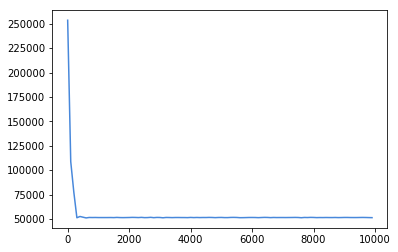

In [38]:
plt.figure()
plt.plot(data[10][0][:,0],data[10][0][:,1],label='kT=0.01',color='#4888db')
#plt.plot(data[10][1][:,0],data[10][1][:,1],label='kT=1.7575',color='#f79501')
#plt.plot(data[10][-1][:,0],data[10][-1][:,1],label='kT=7',color='#c63939')
plt.xlabel('time step')
plt.ylabel('potential_energy')
plt.legend()

IndexError: index 1 is out of bounds for axis 0 with size 1

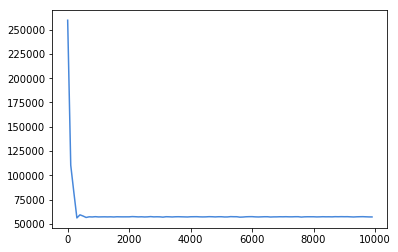

In [43]:
plt.figure()
plt.plot(data[10][0][:,0],data[10][0][:,1]+data[10][0][:,2],label='kT=0.01',color='#4888db')
#plt.plot(data[10][1][:,0],data[10][1][:,1]+data[10][1][:,2],label='kT=kT=1.7575',color='#f79501')
#plt.plot(data[10][-1][:,0],data[10][-1][:,1]+data[10][-1][:,2],label='kT=7',color='#c63939')
plt.xlabel('time step')
plt.ylabel('total_energy')
plt.legend()

Text(0, 0.5, 'g_AA')

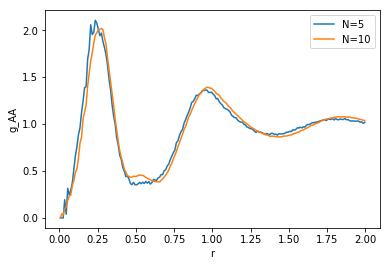

In [74]:
plt.figure()
Sizes = numpy.arange(5,11,5)#numpy.arange(5,11,1)
for N in Sizes:
    plt.plot(EQanalysis[N][0].rdf.R, EQanalysis[N][0].rdf.RDF,label=f"N={N}")
#plt.plot(EQanalysis[10][1].rdf.R, EQanalysis[10][1].rdf.RDF,label='kT=1.7575',color='#f79501')
#plt.plot(EQanalysis[10][-1].rdf.R, EQanalysis[10][-1].rdf.RDF,label='kT=7',color='#c63939')
plt.legend()
plt.xlabel('r')
plt.ylabel('g_AA')

In [ ]:
## Add in read csv for sq text files within testN folder and plot those babies. So txt files in S(q) v q, 
## where q = 2.pi/L, we want S(q) in log plot and q/2.pi to compare to paper

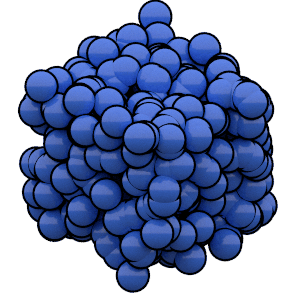

In [71]:
N = 10
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+".gsd") # Takes some time

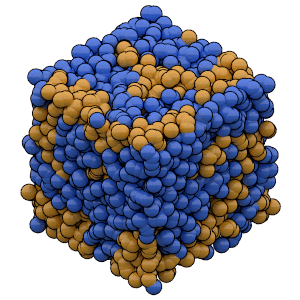

In [72]:
N = 30
ex_render.display_movie(ex_render.render_sphere_frame, "EQtraj-size-"+str(N)+".gsd") # Takes some time